# Introduction

Course: Deep Learing

Author: Oai Tran

Institution: University of Virginia — School of Data Science

Date: 11/07/2025

Notebook Type: Educational / Research — End-to-End Implementation


## Overview
This notebook is the end-to-end process of the final project. The goal of the final project is to predict a stock price and determine whether it is a buy/sell/hold position. 




#### Stage 1

In [1]:
# ==========================================================
#  Stage 1 — VOO Forecast (v2.6)
#  Δ-Target + Conv1D→LSTM + Macro (VIX) | CuDNN-safe & Merge-Safe
# ==========================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import tensorflow as tf
import os
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from datetime import datetime, timedelta


In [2]:

# ----------------------------------------------------------
# 0. Reproducibility & environment setup
# ----------------------------------------------------------
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_USE_CUDNN_RNN"] = "0"   # disable CuDNN RNN kernels
print("TensorFlow:", tf.__version__)


TensorFlow: 2.17.0


In [3]:

# ----------------------------------------------------------
# 1. Load data (VOO + VIX)
# ----------------------------------------------------------
start_date, end_date = "2017-01-01", "2025-09-10"

voo_raw = yf.Ticker("VOO").history(start=start_date, end=end_date, auto_adjust=False)
vix_raw = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)

voo_raw = voo_raw[["Open", "High", "Low", "Close", "Volume"]].dropna()
vix_raw = vix_raw[["Close"]].rename(columns={"Close": "VIX_Close"}).dropna()

# ----------------------------------------------------------
# 1.5 Align and clean data
# ----------------------------------------------------------
# Outer join → keep all dates; forward-fill VIX; drop non-trading days for VOO
df = voo_raw.join(vix_raw, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

print(f"After merge: {df.shape[0]} rows remain ({df.index.min().date()} → {df.index.max().date()})")



After merge: 2183 rows remain (2017-01-03 → 2025-09-09)


/tmp/ipykernel_288623/151996403.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")


/home/dzn7nf/.local/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


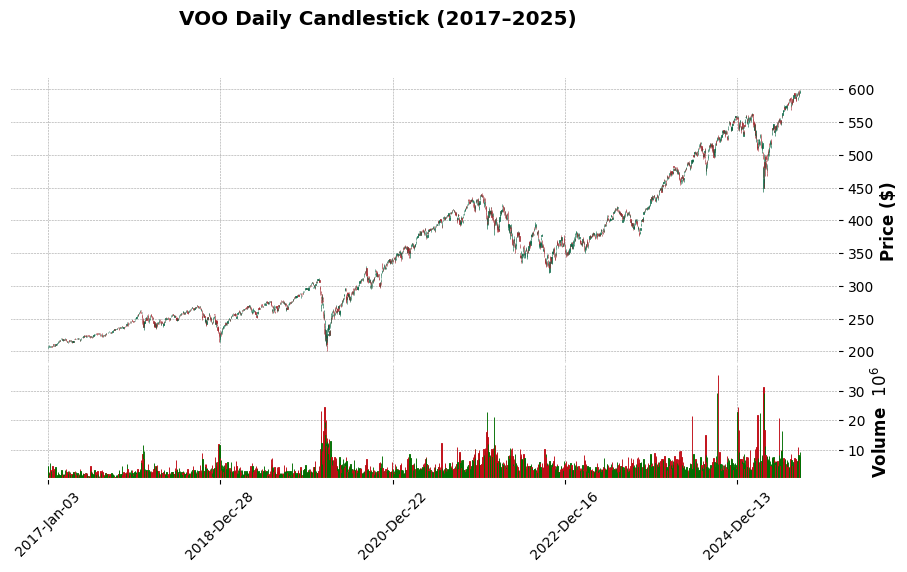

In [4]:
mpf.plot(
    voo_raw,
    type="candle", 
    style="charles",   # clean style
    title="VOO Daily Candlestick (2017–2025)",
    ylabel="Price ($)",
    volume=True,       # adds volume below chart
    figratio=(12,6)
)

In [5]:
# ----------------------------------------------------------
# 2. Feature engineering
# ----------------------------------------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, min_periods=1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"] - df["VIX_Close"].rolling(20, min_periods=1).mean()) / \
                     df["VIX_Close"].rolling(20, min_periods=1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)



In [6]:
# ----------------------------------------------------------
# 3. Target = next-day return (Δ target)
# ----------------------------------------------------------
df["TargetRet1"] = (df["Close"].shift(-1) / df["Close"] - 1.0)
df["PrevClose"]  = df["Close"]
df = df.dropna(subset=["TargetRet1"]).copy()



In [7]:
# ----------------------------------------------------------
# 4. Scale features only (not target)
# ----------------------------------------------------------
feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols, index=df.index)

y_all      = df["TargetRet1"].values.astype("float32")
prev_close = df["PrevClose"].values.astype("float32")
dates_all  = df.index

print(f"Scaled features shape: {scaled_df.shape}")



Scaled features shape: (2182, 10)


In [8]:
# ----------------------------------------------------------
# 5. Sequence builder
# ----------------------------------------------------------
def make_sequences(X_df, y, prev_close, dates, window=12):
    X, y_out, prev_c, d_out = [], [], [], []
    for i in range(len(X_df) - window):
        X.append(X_df.iloc[i:i+window].values)
        y_out.append(y[i+window-1])           # predict ΔClose for t+1
        prev_c.append(prev_close[i+window-1]) # previous close
        d_out.append(dates[i+window])         # target date
    return np.array(X), np.array(y_out), np.array(prev_c), np.array(d_out)

window = 12
X, y, prev_c, dts = make_sequences(scaled_df, y_all, prev_close, dates_all, window=window)
split = int(len(X)*0.8)

X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]
pc_tr, pc_te = prev_c[:split], prev_c[split:]
dt_tr, dt_te = dts[:split], dts[split:]

print(f"Train: {X_tr.shape},  Test: {X_te.shape}")



Train: (1736, 12, 10),  Test: (434, 12, 10)


In [9]:
# ----------------------------------------------------------
# 6. Conv1D → LSTM model (CuDNN-safe)
# ----------------------------------------------------------
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True, unroll=True,
             activation='tanh', recurrent_activation='sigmoid'),
        Dropout(0.1),
        LSTM(32, unroll=True, activation='tanh', recurrent_activation='sigmoid'),
        Dense(32, activation='relu'),
        Dense(1)  # predict next-day return
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt, loss='mse')
    return model

model = build_model((window, X_tr.shape[2]))
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=120,
    batch_size=16,
    verbose=1,
    callbacks=[es]
)



'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/120


W0000 00:00:1763515302.560816  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.579745  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.602165  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.605427  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.609843  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.635605  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.635768  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.638705  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515302.638792  288709 gp

  2/109 [..............................] - ETA: 5s - loss: 6.1143e-04  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763515305.362398  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.362489  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.362554  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.362609  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.362661  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.362723  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.362796  288709 gpu_timer.cc:114] Skipping

 16/109 [===>..........................] - ETA: 1s - loss: 2.2630e-04

W0000 00:00:1763515305.528223  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528278  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528349  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528426  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528491  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528561  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528627  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528696  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515305.528764  288709 gp

109/109 [==============================] - ETA: 0s - loss: 1.5552e-04

W0000 00:00:1763515306.070088  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070178  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070232  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070306  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070385  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070450  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070521  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070583  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.070650  288709 gp

109/109 [==============================] - 6s 11ms/step - loss: 1.5552e-04 - val_loss: 1.0778e-04
Epoch 2/120
 18/109 [===>..........................] - ETA: 0s - loss: 1.5867e-04

W0000 00:00:1763515306.423645  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.441836  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.441958  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.442069  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.442170  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.442238  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.442313  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.442390  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.442463  288709 gp

109/109 [==============================] - 0s 5ms/step - loss: 1.5048e-04 - val_loss: 1.0676e-04
Epoch 3/120
  1/109 [..............................] - ETA: 0s - loss: 5.6569e-05

W0000 00:00:1763515306.906820  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907203  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907261  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907335  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907414  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907490  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907562  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907628  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515306.907694  288709 gp

109/109 [==============================] - 0s 4ms/step - loss: 1.5022e-04 - val_loss: 1.2260e-04
Epoch 4/120
 35/109 [========>.....................] - ETA: 0s - loss: 1.6201e-04

W0000 00:00:1763515307.407157  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407250  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407322  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407386  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407456  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407522  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407588  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407654  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.407721  288709 gp

109/109 [==============================] - 0s 4ms/step - loss: 1.5332e-04 - val_loss: 1.0908e-04
Epoch 5/120
 30/109 [=======>......................] - ETA: 0s - loss: 1.3270e-04

W0000 00:00:1763515307.822466  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822563  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822635  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822700  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822769  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822836  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822903  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.822969  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515307.823037  288709 gp

109/109 [==============================] - 0s 4ms/step - loss: 1.5135e-04 - val_loss: 1.0790e-04
Epoch 6/120
109/109 [==============================] - 0s 4ms/step - loss: 1.5160e-04 - val_loss: 1.0756e-04
Epoch 7/120
109/109 [==============================] - 0s 4ms/step - loss: 1.5068e-04 - val_loss: 1.0926e-04
Epoch 8/120
109/109 [==============================] - 0s 4ms/step - loss: 1.5212e-04 - val_loss: 1.0682e-04
Epoch 9/120
109/109 [==============================] - 0s 4ms/step - loss: 1.5106e-04 - val_loss: 1.0895e-04
Epoch 10/120
109/109 [==============================] - 0s 4ms/step - loss: 1.5026e-04 - val_loss: 1.0757e-04


In [10]:
# ----------------------------------------------------------
# 7. Predict → reconstruct prices
# ----------------------------------------------------------
y_pred_ret = model.predict(X_te).flatten()
y_pred_price = pc_te * (1.0 + y_pred_ret)
y_true_price = pc_te * (1.0 + y_te)

# ----------------------------------------------------------
# 8. Metrics
# ----------------------------------------------------------
mape = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100
mae  = mean_absolute_error(y_true_price, y_pred_price)
rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
r2   = r2_score(y_true_price, y_pred_price)

print(f"MAPE={mape:.2f}% | MAE=${mae:.2f} | RMSE=${rmse:.2f} | R²={r2:.3f}")



14/14 [==============================] - 0s 4ms/step
MAPE=0.67% | MAE=$3.44 | RMSE=$5.18 | R²=0.985


W0000 00:00:1763515310.587035  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587124  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587180  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587253  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587334  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587398  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587468  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587534  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515310.587602  288709 gp

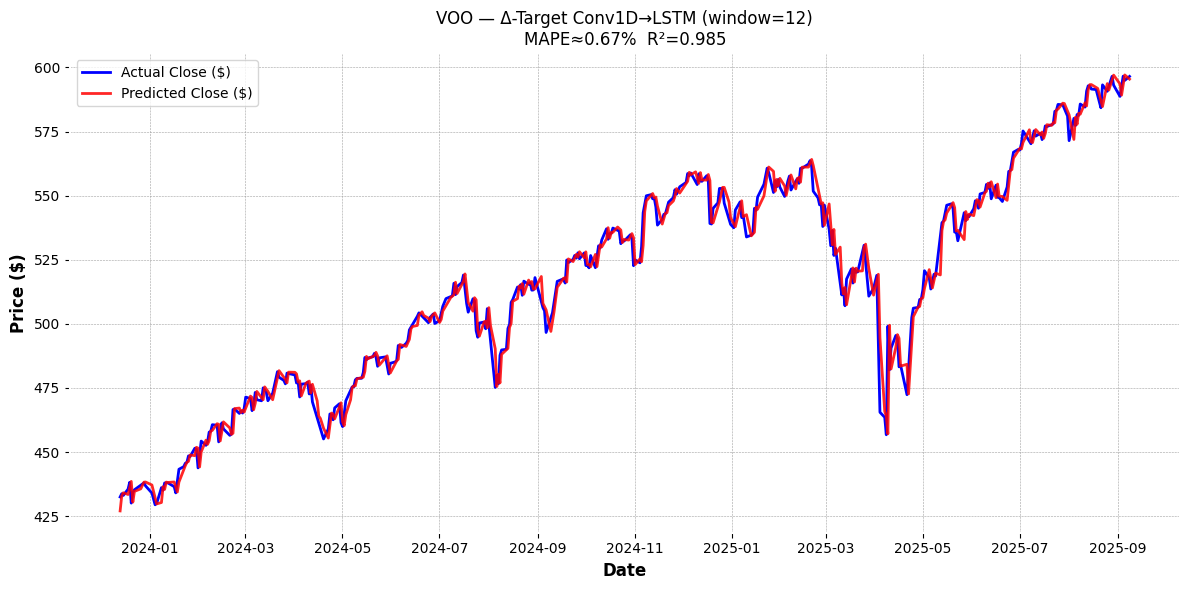

In [11]:
# ----------------------------------------------------------
# 8. Plot results
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(dt_te, y_true_price, label="Actual Close ($)", color="blue")
plt.plot(dt_te, y_pred_price, label="Predicted Close ($)", color="red", alpha=0.85)
plt.title(f"VOO — Δ-Target Conv1D→LSTM (window={window})\nMAPE≈{mape:.2f}%  R²={r2:.3f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# 9. Save model + scaler
# ----------------------------------------------------------
os.makedirs("models", exist_ok=True)
model.save("models/VOO_stage1_v26.h5")
joblib.dump(scaler, "models/VOO_scaler_v26.pkl")
print("Model & scaler saved to ./models/")

Model & scaler saved to ./models/


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Stage 2

W0000 00:00:1763515311.575074  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575164  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575219  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575290  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575374  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575438  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575512  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575582  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515311.575649  288709 gp

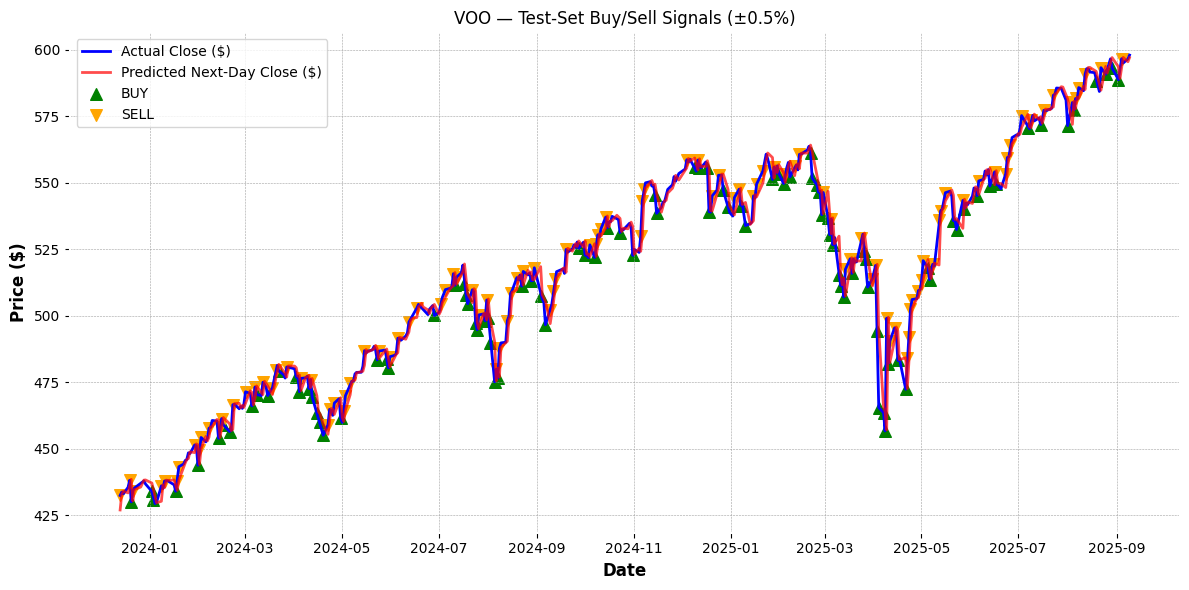

=== TEST-SET RESULTS ===
Strategy  → CAGR -48.60%, Vol 10.14%, Sharpe -4.79
Buy&Hold → CAGR 21.59%, Vol 16.40%, Sharpe 1.32


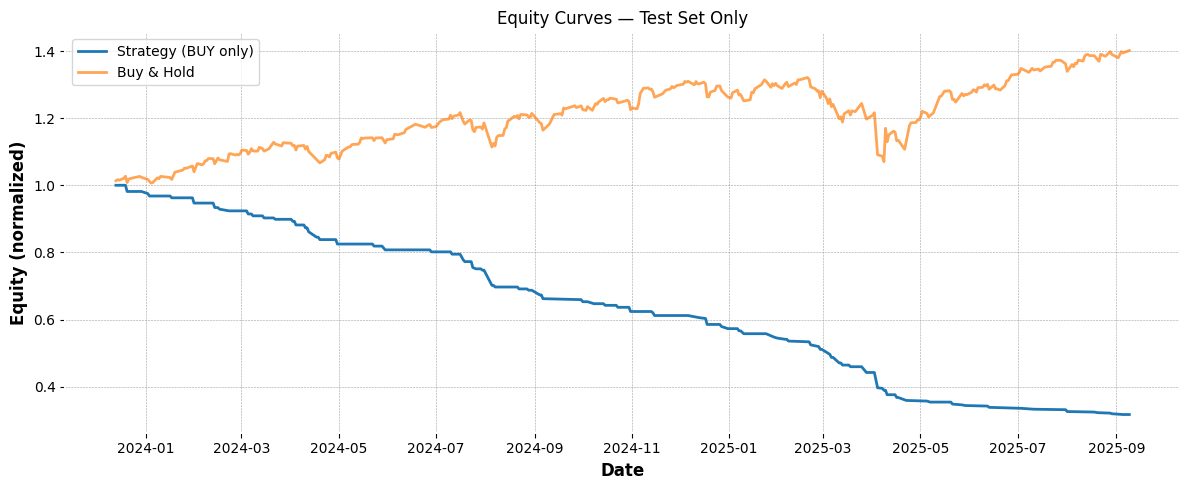


Recent test-period signals:
                               Actual   Predicted    Gap(%) Signal
2025-08-26 04:00:00+00:00  593.059998  591.186875 -0.315840   HOLD
2025-08-27 04:00:00+00:00  594.419983  593.549795 -0.146393   HOLD
2025-08-28 04:00:00+00:00  596.520020  594.905802 -0.270606   HOLD
2025-08-29 04:00:00+00:00  593.080017  597.013812  0.663282    BUY
2025-09-02 04:00:00+00:00  588.710022  593.565377  0.824745    BUY
2025-09-03 04:00:00+00:00  591.719971  589.196437 -0.426474   HOLD
2025-09-04 04:00:00+00:00  596.590027  592.211130 -0.733988   SELL
2025-09-05 04:00:00+00:00  594.960022  597.080464  0.356401   HOLD
2025-09-08 04:00:00+00:00  596.500000  595.447559 -0.176436   HOLD
2025-09-09 04:00:00+00:00  597.950012  596.979484 -0.162309   HOLD
Saved: artifacts/stage2_signals_VOO.csv
Saved: models/stage2_config_VOO.pkl
Saved placeholder model: models/stage2_direct_signal_placeholder_VOO.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:

#  Stage 2 (Direct Signal, Test Only)
#  v2.4 — Plot & Backtest only on Stage-1 test split

# ----------------------------
# Config
# ----------------------------
TICKER = "VOO"
START, END = "2017-01-01", "2025-09-10"
WINDOW = 12
THRESH = 0.005   # 0.5% price gap threshold for Buy/Sell
TEST_RATIO = 0.2

# ----------------------------
# Load price data (VOO + VIX)
# ----------------------------
voo = yf.Ticker(TICKER).history(start=START, end=END, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=START, end=END, auto_adjust=False)
voo = voo[["Open","High","Low","Close","Volume"]].dropna()
vix = vix[["Close"]].rename(columns={"Close":"VIX_Close"}).dropna()

df = voo.join(vix, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open","High","Low","Close","Volume"]).copy()

# ----------------------------
# Load Stage-1 model + scaler
# ----------------------------
model_path = "models/VOO_stage1_v26.h5"
scaler_path = "models/VOO_scaler_v26.pkl"
assert os.path.exists(model_path), "Stage-1 model not found!"
assert os.path.exists(scaler_path), "Stage-1 scaler not found!"

model = tf.keras.models.load_model(model_path, compile=False)
scaler = joblib.load(scaler_path)

# ----------------------------
# Feature engineering (same schema)
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20,1).mean()) / df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open","High","Low","Close","Volume",
    "Ret1","Momentum5","Volatility5","LogVolume","VIX_Z"
]
scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Build rolling input windows
# ----------------------------
def make_seq(Xdf, window=WINDOW):
    Xs, dates = [], []
    for i in range(len(Xdf)-window):
        Xs.append(Xdf.iloc[i:i+window].values)
        dates.append(Xdf.index[i+window])
    return np.array(Xs), np.array(dates)

Xseq, dates = make_seq(scaled_df, window=WINDOW)
pred_ret = model.predict(Xseq, verbose=0).flatten()

# ----------------------------
# Reconstruct predicted prices
# ----------------------------
close_vals = df["Close"].values
pred_price = close_vals[WINDOW-1:-1] * (1 + pred_ret)
actual_price = close_vals[WINDOW:]
dates = np.array(dates)

# ----------------------------
# Split train/test (chronological)
# ----------------------------
split_idx = int(len(pred_price)*(1-TEST_RATIO))
pred_price_test = pred_price[split_idx:]
actual_price_test = actual_price[split_idx:]
dates_test = dates[split_idx:]

# ----------------------------
# Generate BUY / SELL / HOLD on test only
# ----------------------------
gap = (pred_price_test - actual_price_test) / actual_price_test
signals = np.zeros_like(pred_price_test)
signals[gap > THRESH]  = 1    # BUY
signals[gap < -THRESH] = -1   # SELL
signal_labels = np.where(signals==1,"BUY",np.where(signals==-1,"SELL","HOLD"))

df_signals = pd.DataFrame({
    "Actual": actual_price_test,
    "Predicted": pred_price_test,
    "Gap(%)": gap*100,
    "Signal": signal_labels
}, index=dates_test)

# ----------------------------
# Plot (TEST only)
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_signals.index, df_signals["Actual"], label="Actual Close ($)", color="blue")
plt.plot(df_signals.index, df_signals["Predicted"], label="Predicted Next-Day Close ($)", color="red", alpha=0.7)
plt.scatter(df_signals.index[df_signals["Signal"]=="BUY"], df_signals["Actual"][df_signals["Signal"]=="BUY"], 
            marker="^", color="green", label="BUY", s=70)
plt.scatter(df_signals.index[df_signals["Signal"]=="SELL"], df_signals["Actual"][df_signals["Signal"]=="SELL"], 
            marker="v", color="orange", label="SELL", s=70)
plt.title(f"{TICKER} — Test-Set Buy/Sell Signals (±{THRESH*100:.1f}%)")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ----------------------------
# Simple backtest (TEST only)
# ----------------------------
returns = pd.Series(df["Close"]).pct_change().reindex(df_signals.index).fillna(0)
positions = np.where(df_signals["Signal"]=="BUY", 1.0, 0.0)
strategy_returns = returns * positions
eq_curve = (1 + strategy_returns).cumprod()
bh_curve = (1 + returns).cumprod()

def ann_metrics(r):
    cagr = (1.0 + r).prod() ** (252/len(r)) - 1.0
    vol  = r.std() * np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    return cagr, vol, sharpe

cagr_s, vol_s, sh_s = ann_metrics(strategy_returns)
cagr_b, vol_b, sh_b = ann_metrics(returns)

print(f"=== TEST-SET RESULTS ===")
print(f"Strategy  → CAGR {cagr_s:.2%}, Vol {vol_s:.2%}, Sharpe {sh_s:.2f}")
print(f"Buy&Hold → CAGR {cagr_b:.2%}, Vol {vol_b:.2%}, Sharpe {sh_b:.2f}")

plt.figure(figsize=(12,5))
plt.plot(eq_curve.index, eq_curve.values, label="Strategy (BUY only)")
plt.plot(bh_curve.index, bh_curve.values, label="Buy & Hold", alpha=0.7)
plt.title("Equity Curves — Test Set Only")
plt.xlabel("Date"); plt.ylabel("Equity (normalized)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

print("\nRecent test-period signals:")
print(df_signals.tail(10))


os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# 1 Save signal dataframe (test predictions)
df_signals.to_csv("artifacts/stage2_signals_VOO.csv")
print("Saved: artifacts/stage2_signals_VOO.csv")

# 2 Save the rule parameters as a tiny dict (so we can reload later)
stage2_config = {
    "ticker": TICKER,
    "window": WINDOW,
    "threshold": THRESH,
    "test_ratio": TEST_RATIO,
    "feature_cols": feature_cols,
    "metrics": {
        "strategy_cagr": float(cagr_s),
        "strategy_vol":  float(vol_s),
        "strategy_sharpe": float(sh_s)
    }
}
joblib.dump(stage2_config, "models/stage2_config_VOO.pkl")
print("Saved: models/stage2_config_VOO.pkl")

# 3 Optional: save a lightweight “direct-signal model” placeholder
# (just to mark this stage so ensemble loader can find it)
placeholder = Sequential([Dense(1, input_shape=(1,))])
placeholder.save("models/stage2_direct_signal_placeholder_VOO.h5")
print("Saved placeholder model: models/stage2_direct_signal_placeholder_VOO.h5")

In [14]:
# ==========================================================
#  Stage 2 — CNN + SVM Training and Save
# ==========================================================

# ----------------------------
# Config
# ----------------------------
TICKER = "VOO"
START, END = "2017-01-01", "2025-09-10"
WINDOW = 7
EPOCHS, BATCH = 40, 32
os.makedirs("models", exist_ok=True)

# ----------------------------
# Load VOO + VIX
# ----------------------------
voo = yf.Ticker(TICKER).history(start=START, end=END, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=START, end=END, auto_adjust=False)
df = voo.join(vix[["Close"]].rename(columns={"Close":"VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df[["Open","High","Low","Close","Volume","VIX_Close"]].dropna()

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"]-df["VIX_Close"].rolling(20,1).mean())/df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)

features = ["Open","High","Low","Close","Volume","Ret1","Momentum5",
            "Volatility5","LogVolume","VIX_Z"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

# ----------------------------
# Build CNN “images” and labels
# ----------------------------
def make_seq(df_scaled, horizon=1, window=WINDOW):
    X, y = [], []
    closes = df["Close"].values
    for i in range(len(df_scaled)-window-horizon):
        X.append(df_scaled.iloc[i:i+window].values.T)
        fwd_ret = (closes[i+window+horizon-1]-closes[i+window-1]) / closes[i+window-1]
        y.append(1 if fwd_ret>0 else 0)  # 1=Up, 0=Down
    return np.array(X), np.array(y)

X, y = make_seq(scaled_df)
X = X[..., np.newaxis]
print("Dataset:", X.shape, y.shape)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# CNN model
# ----------------------------
inp = Input(shape=(X.shape[1], X.shape[2], 1))
x = Conv2D(32, (3,3), padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(2, activation="softmax")(x)

cnn = Model(inp, out)
cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
es = EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
cnn.fit(Xtr, ytr, validation_data=(Xte, yte),
        epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)

cnn.save("models/stage2_cnn_VOO.h5")
print("Saved: models/stage2_cnn_VOO.h5")

# ----------------------------
# SVM on CNN embeddings
# ----------------------------
embed_model = Model(inputs=cnn.input, outputs=cnn.layers[-3].output)
emb_tr = embed_model.predict(Xtr, verbose=0)
emb_te = embed_model.predict(Xte, verbose=0)

svm = SVC(kernel="rbf", probability=True)
svm.fit(emb_tr, ytr)
acc = svm.score(emb_te, yte)
print(f"SVM accuracy: {acc:.3f}")
joblib.dump(svm, "models/stage2_svm_VOO.pkl")
print("Saved: models/stage2_svm_VOO.pkl")


Dataset: (2174, 10, 7, 1) (2174,)
Epoch 1/40


W0000 00:00:1763515313.267784  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.268657  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.343918  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.344016  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.344089  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.344164  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.344226  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.344323  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515313.370568  288709 gp

 3/55 [>.............................] - ETA: 1s - loss: 1.7828 - accuracy: 0.5938  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763515314.058951  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.059049  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.059117  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.059206  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.059274  288709 gpu_timer.cc:114] Skipping the delay kernel, measu

55/55 [==============================] - ETA: 0s - loss: 0.8822 - accuracy: 0.5181

W0000 00:00:1763515314.238785  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.238882  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.238939  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.239007  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.239077  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.239165  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.239238  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.239321  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.239401  288709 gp

55/55 [==============================] - 2s 8ms/step - loss: 0.8822 - accuracy: 0.5181 - val_loss: 0.6954 - val_accuracy: 0.4322
Epoch 2/40
55/55 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5308

W0000 00:00:1763515314.492178  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492268  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492326  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492396  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492460  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492547  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492622  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492711  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.492791  288709 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5308 - val_loss: 0.6966 - val_accuracy: 0.4506
Epoch 3/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5463 - val_loss: 0.6904 - val_accuracy: 0.5379


W0000 00:00:1763515314.730833  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.730922  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.730979  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.731050  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.731113  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.731201  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.731275  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.731364  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515314.731444  288709 gp

Epoch 4/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5474 - val_loss: 0.6861 - val_accuracy: 0.5770
Epoch 5/40
45/55 [=======================>......] - ETA: 0s - loss: 0.6868 - accuracy: 0.5389

W0000 00:00:1763515315.115083  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115178  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115234  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115289  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115359  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115429  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115501  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115570  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515315.115648  288709 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5417 - val_loss: 0.6838 - val_accuracy: 0.5724
Epoch 6/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5497 - val_loss: 0.6833 - val_accuracy: 0.5724
Epoch 7/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5446 - val_loss: 0.6837 - val_accuracy: 0.5586
Epoch 8/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5469 - val_loss: 0.6915 - val_accuracy: 0.5425
Epoch 9/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5497 - val_loss: 0.7137 - val_accuracy: 0.4782
Epoch 10/40
55/55 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5538 - val_loss: 0.6849 - val_accuracy: 0.5816
Epoch 11/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5480 - val_loss: 0.7030 - val_accuracy: 0.4782
Epoch 12/40
55/55 [==========

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


SVM accuracy: 0.469
Saved: models/stage2_svm_VOO.pkl


#### Stage 3

In [15]:
# ==========================================================
#  Predict next-day open and close price + signal
#  Interactive Jupyter version
# ==========================================================

# ----------------------------
# Config
# ----------------------------
VIX = "^VIX"
WINDOW_LSTM = 12
WINDOW_CNN = 7
THRESH = 0.02  # 2% threshold for signal
LOOKBACK = 200  # days before target date for context

# ----------------------------
# Ask user inputs
# ----------------------------
ticker = input("Enter stock ticker (e.g., VOO, AAPL, MSFT): ").strip().upper()
while True:
    date_str = input("Enter date (YYYY-MM-DD): ").strip()
    try:
        target_date = datetime.strptime(date_str, "%Y-%m-%d")
        break
    except ValueError:
        print("Invalid format. Please use YYYY-MM-DD (e.g., 2025-11-06).")

# ----------------------------
# Load models VOO_stage1_v26 VOO_scaler_v26.pkl
# ----------------------------
stage1_path = "models/VOO_stage1_v26.h5"
scaler_path = "models/VOO_scaler_v26.pkl"
cnn_path = "models/stage2_cnn_VOO.h5"
svm_path = "models/stage2_svm_VOO.pkl"

assert os.path.exists(stage1_path), "Missing Stage 1 model"
assert os.path.exists(scaler_path), "Missing Stage 1 scaler"
model_stage1 = tf.keras.models.load_model(stage1_path, compile=False)
scaler = joblib.load(scaler_path)

cnn_model, svm = None, None
if os.path.exists(cnn_path) and os.path.exists(svm_path):
    cnn_model = tf.keras.models.load_model(cnn_path, compile=False)
    svm = joblib.load(svm_path)

# ----------------------------
# Load price data
# ----------------------------
start_date = (target_date - timedelta(days=LOOKBACK)).strftime("%Y-%m-%d")
end_date = (target_date + timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching {ticker} and VIX data up to {target_date.date()}...")
stock = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker(VIX).history(start=start_date, end=end_date, auto_adjust=False)

if stock.empty:
    raise ValueError(f"No data found for {ticker}. Check the ticker symbol.")

df = stock.join(vix[["Close"]].rename(columns={"Close": "VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"] = df["Close"].pct_change().fillna(0.0)
df["Momentum5"] = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, 1).std().fillna(0.0)
df["LogVolume"] = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20, 1).mean()) / df["VIX_Close"].rolling(20, 1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Stage 1 — LSTM price predictions (Open + Close)
# ----------------------------
X_last = scaled_df.iloc[-WINDOW_LSTM:].values.reshape(1, WINDOW_LSTM, -1)

# predict close
pred_ret_close = model_stage1.predict(X_last, verbose=0).flatten()[0]
pred_close_price = df["Close"].iloc[-1] * (1 + pred_ret_close)

# predict open (shift features by 1 day to simulate next open)
X_last_shifted = scaled_df.iloc[-(WINDOW_LSTM+1):-1].values.reshape(1, WINDOW_LSTM, -1)
pred_ret_open = model_stage1.predict(X_last_shifted, verbose=0).flatten()[0]
pred_open_price = df["Open"].iloc[-1] * (1 + pred_ret_open)

print(f"Stage 1 predicts:")
print(f"   → Next Open ≈ ${pred_open_price:.2f} ({pred_ret_open*100:.3f}% change)")
print(f"   → Next Close ≈ ${pred_close_price:.2f} ({pred_ret_close*100:.3f}% change)")

# ----------------------------
# Stage 2 — CNN + SVM direction signal (if available)
# ----------------------------
stage2_signal, cnn_conf = 0, 0.0
if cnn_model and svm:
    cnn_input = scaled_df.iloc[-WINDOW_CNN:].values.T.reshape(1, len(feature_cols), WINDOW_CNN, 1)

    cnn_embed_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
    cnn_embed = cnn_embed_model.predict(cnn_input, verbose=0)

    cnn_logits = cnn_model.predict(cnn_input, verbose=0)
    cnn_pred = np.argmax(cnn_logits, axis=1)[0]
    cnn_conf = cnn_logits[0][cnn_pred]

    stage2_signal = svm.predict(cnn_embed)[0]
    stage2_signal = 1 if stage2_signal == 1 else -1
    print(f"Stage 2 predicts: {'BUY' if stage2_signal==1 else 'SELL'} (conf={cnn_conf:.2f})")
else:
    print("Stage 2 not available — using Stage 1 only.")

# ----------------------------
# Combine predictions → Final Signal
# ----------------------------
if stage2_signal == 1 and pred_ret_close > THRESH:
    action = "BUY"
elif stage2_signal == -1 and pred_ret_close < -THRESH:
    action = "SELL"
elif abs(pred_ret_close) < THRESH / 2:
    action = "HOLD"
else:
    action = "BUY" if pred_ret_close > 0 else "SELL"



Enter stock ticker (e.g., VOO, AAPL, MSFT):  VOO
Enter date (YYYY-MM-DD):  2025-11-02


Fetching VOO and VIX data up to 2025-11-02...


W0000 00:00:1763515326.552955  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553045  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553100  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553172  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553258  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553321  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553392  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553460  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.553526  288709 gp

Stage 1 predicts:
   → Next Open ≈ $630.32 (0.077% change)
   → Next Close ≈ $627.53 (0.078% change)
Stage 2 predicts: SELL (conf=0.56)


W0000 00:00:1763515326.804120  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804220  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804279  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804350  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804413  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804501  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804573  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804662  288709 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763515326.804740  288709 gp

In [16]:
# ----------------------------
# Display final result
# ----------------------------
print("\nFINAL PREDICTION RESULT")
print(f"Ticker: {ticker}")
print(f"Date: {target_date.strftime('%Y-%m-%d')}")
print(f"Latest available close: ${df['Close'].iloc[-1]:.2f}")
print(f"Predicted next OPEN: ${pred_open_price:.2f}")
print(f"Predicted next CLOSE: ${pred_close_price:.2f}")
print(f"Predicted return: {pred_ret_close*100:.3f}%")
print(f"Signal: {'BUY' if action=='BUY' else ('SELL' if action=='SELL' else 'HOLD')}")



FINAL PREDICTION RESULT
Ticker: VOO
Date: 2025-11-02
Latest available close: $627.04
Predicted next OPEN: $630.32
Predicted next CLOSE: $627.53
Predicted return: 0.078%
Signal: HOLD
